In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance

plt.rcParams.update({'font.size': 13}) 

PARAMETERS = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']
PARAMETERS_NAME = [r'$k^{0}_{\parallel}$', r'$a_{\parallel}$', r'$a_{\perp}$', r'$b_{\parallel}$', r'$b_{\perp}$'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 

## Relevant functions from utils.py
Can't just import utils since path to data is different than utils.py

In [24]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

In [25]:
def _as_array(x):
    """Get a float64 NumPy array from a pandas Series/array-like."""
    # Works for pandas Series (has .values) and plain np arrays/lists
    try:
        return np.asarray(x.values, dtype=float)
    except AttributeError:
        return np.asarray(x, dtype=float)

def _rhat_from_chains(chains_2d: np.ndarray,
                      ensure_ge1: bool = True,
                      return_details: bool = False):
    """
    Compute Gelman–Rubin R-hat from multiple chains following the 4-step description from 
    https://mystatisticsblog.blogspot.com/2019/04/gelman-rubin-convergence-criteria-for.html. 
    Assumes chains are already prepared (e.g., only second halves if that's your convention), 
    so that `chains_2d` has shape (m, n) with m = #chains and n = samples/chain.

    Steps implemented:
      1) (Warmup removal is assumed done before this function.)
      2) Per-chain mean & variance:  θ̄_j and σ²(θ_j)
      3) Mean-of-means θ̄̄, mean within-chain variance σ̄²(θ),
         variance of chain means σ²(θ̄)
         Then B_j = σ²(θ̄) − (1/n) σ̄²(θ)
      4) R̂ = sqrt( 1 + B_j / σ̄²(θ) )

    Also computes the classic equivalent:
      W = σ̄²(θ), B = n * σ²(θ̄),
      Var⁺ = ((n−1)/n) W + (B/n),
      R̂_classic = sqrt(Var⁺ / W)

    Args
    ----
    chains_2d : np.ndarray
        Shape (m, n): m chains, n samples per chain.
    ensure_ge1 : bool
        If True, clamp R-hat to be at least 1.0 (common practice).
    return_details : bool
        If True, return (rhat, details_dict). Otherwise return rhat (float).

    Returns
    -------
    rhat : float
    (optionally) details : dict with intermediate quantities
    """
    if chains_2d.ndim != 2:
        raise ValueError("chains_2d must have shape (m, n).")
    m, n = chains_2d.shape
    if m < 2 or n < 2:
        out = np.nan
        return (out, {}) if return_details else out

    # Step 2: per-chain means and variances (unbiased)
    theta_bar_j = chains_2d.mean(axis=1)             # θ̄_j
    sigma2_theta_j = chains_2d.var(axis=1, ddof=1)   # σ²(θ_j), unbiased

    # Step 3: across-chain aggregates
    theta_barbar = theta_bar_j.mean()                              # θ̄̄
    sigma2_bar_theta = sigma2_theta_j.mean()                       # σ̄²(θ) = W
    sigma2_theta_bar = theta_bar_j.var(ddof=1)                     # σ²(θ̄)
    B_j = sigma2_theta_bar - (sigma2_bar_theta / n)                # B_j

    # Step 4: scale reduction
    if sigma2_bar_theta <= 0:
        rhat = np.nan
    else:
        rhat = float(np.sqrt(1.0 + (B_j / sigma2_bar_theta)))

    # Optional clamp to ≥ 1
    if ensure_ge1 and np.isfinite(rhat):
        if rhat < 1.0:
            rhat = 1.0

    # Classic form (for verification / curiosity)
    W = sigma2_bar_theta
    B = n * sigma2_theta_bar
    var_plus = ((n - 1) / n) * W + (B / n)
    rhat_classic = float(np.sqrt(var_plus / W)) if W > 0 else np.nan

    if return_details:
        details = {
            "m": m, "n": n,
            "theta_bar_j": theta_bar_j,          # per-chain means
            "sigma2_theta_j": sigma2_theta_j,    # per-chain variances
            "theta_barbar": theta_barbar,        # mean of means
            "sigma2_bar_theta": sigma2_bar_theta,# mean within-chain var (W)
            "sigma2_theta_bar": sigma2_theta_bar,# variance of chain means
            "B_j": B_j,
            "W": W, "B": B, "var_plus": var_plus,
            "rhat_equation_form": rhat,
            "rhat_classic_equivalent": rhat_classic
        }
        return rhat, details
    else:
        return rhat

def compute_rhat(
    chains_samples,
    params=PARAMETERS,
    mode: str = "split",   # "split" or "last_half"
    thin: int = 1,
    return_details: bool = False
):
    """
    Compute R-hat for each parameter across multiple HMC chains.

    Args:
      chains_samples: list of dict[param -> pd.Series/np.ndarray]
      params: list of parameter names to compute.
      mode:
        - "split": split each chain into two halves → shape (2*#chains, N/2)
        - "last_half": keep only the second half of each chain → shape (#chains, N/2)
      thin: keep every 'thin'-th sample (applied after halving/splitting prep)

    Returns:
      dict[param -> rhat_value]
    """
    assert mode in {"split", "last_half"}, "mode must be 'split' or 'last_half'"
    rhats = {}

    for p in params:
        segments = []  # list of 1D arrays to be stacked into (m, n)

        # Build per-chain segments according to the selected mode
        for ch in chains_samples:
            if p not in ch:
                continue
            x = _as_array(ch[p])
            if x.size < 4:
                continue  # too short to halve/split sensibly

            n = x.size
            half = n // 2

            if mode == "last_half":
                seg = x[half:]              # keep only the second half
                seg = seg[::thin]           # thin
                if seg.size >= 2:
                    segments.append(seg)

            elif mode == "split":
                first = x[:half]
                second = x[-half:]
                first = first[::thin]
                second = second[::thin]
                if first.size >= 2:
                    segments.append(first)
                if second.size >= 2:
                    segments.append(second)

        # Need at least 2 (sub)chains total
        if len(segments) < 2:
            rhats[p] = np.nan
            continue

        # Align lengths across segments
        segment_lengths = [len(s) for s in segments]
        n_min = np.min(segment_lengths)
        if n_min < 2:
            rhats[p] = np.nan
            continue

        chains_2d = np.stack([s[:n_min] for s in segments])  # shape (m, n_min)
        rhats[p] = _rhat_from_chains(chains_2d, return_details=return_details)

    return rhats

def get_distance(hist_0, hist_1, metric='mae'):
    """
    Compute distance between two histograms.
    """
    num_bins = len(hist_0)
    if len(hist_1) != num_bins:
        raise ValueError(f"Histograms must have the same number of bins. {len(hist_0)} != {len(hist_1)}")
    
    if metric == 'mae':
        return np.abs(hist_0 - hist_1).sum() / num_bins
    elif metric == 'mse':
        return ((hist_0 - hist_1) ** 2).sum() / num_bins
    elif metric == 'kl':
        return kl_div(hist_0, hist_1).sum()
    elif metric == 'wasserstein':
        return wasserstein_distance(hist_0, hist_1)
    else:
        raise ValueError(f"Unknown metric {metric}.")

# Now calculate the average over all 0-132 runs

In [26]:
# Parameters (change me!)
# train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_fractions = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
data_version=['d1', 'd2', 'd3', 'd4', 'd5'] 
model_version=['init1', 'init2', 'init3', 'init4', 'init5'] 
hmc_run = ['hmc1', 'hmc2', 'hmc3', 'hmc4', 'hmc5']
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true
which_changes = ["hmc_init", "model_init", "bootstrapped_data"] 
which_changes_short = ["HMC", "Model", "Data"]
hmc_version='v34_trial5_full_100000'

output_file = f'../../../results/{hmc_version}/plots/all_changes_all_train_sizes_all_intervals_rhat_statistic.csv'
write_new_file = False
print(f"{write_new_file}: Writing to {output_file}.")

# Calculate the distance, but take average over the 133 time intervals
df = index_mcmc_runs(file_version='2023')

# Only keep 'neg' polarity
df = df[df.polarity == 'neg'].copy(deep=True)
print(df.shape)

False: Writing to ../../../results/v34_trial5_full_100000/plots/all_changes_all_train_sizes_all_intervals_rhat_statistic.csv.
(133, 12)


In [27]:
num_bins = 30

# Create a file to write the distance
if write_new_file:
    with open(output_file, 'w') as f:
        f.write(f"train_size_fraction,param,df_index,which_change,rhat\n")
    
    for which_change in which_changes:
        print(f"Processing which_change {which_change}...")

        if which_change == "bootstrapped_data":
            data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_2 = f"{data_version[2]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_3 = f"{data_version[3]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_4 = f"{data_version[4]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        elif which_change == "model_init":
            data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[2]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[3]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[4]}_{hmc_run[0]}"
        elif which_change == "hmc_init":
            data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
            data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"
            data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[2]}"
            data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[3]}"
            data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[4]}"

        # Calculate the k;_divergence for each parameter and train size
        for i, train_size_fraction in enumerate(train_fractions):
            print(f"\n-----------------\nProcessing train size fraction {train_size_fraction}...")
            results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
            results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
            results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
            results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"
            results_dir_hmc_4 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_4}_{train_size_fraction}/"

            # Load the samples from each hmc run, get average per parameter and stdev
            for idx in range(df.shape[0]):
                print(f"Processing df index {idx}...")
                # Load info from the df for index idx
                exp_name = df.experiment_name.iloc[idx]
                interval = df.interval.iloc[idx]
                polarity = df.polarity.iloc[idx]

                # Load the samples from each hmc run
                # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
                # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
                try:
                    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_4_samples = pd.read_csv(f'{results_dir_hmc_4}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

                    hmc_0_samples.columns = PARAMETERS
                    hmc_1_samples.columns = PARAMETERS
                    hmc_2_samples.columns = PARAMETERS
                    hmc_3_samples.columns = PARAMETERS
                    hmc_4_samples.columns = PARAMETERS
                    
                except FileNotFoundError as e:
                    print(f"File not found for train size fraction {train_size_fraction}: {e}")
                    continue

                    
                chains_samples = [hmc_0_samples, hmc_1_samples, hmc_2_samples, hmc_3_samples, hmc_4_samples]
                rhats = compute_rhat(chains_samples, params=PARAMETERS, mode='split', thin=1, return_details=False)

                for param, rhat in rhats.items():
                    if isinstance(rhat, tuple):
                        rhat_value, details = rhat
                    else:
                        rhat_value = rhat
                    print(f"Which change {which_change}, train size fraction {train_size_fraction}, param {param}, R-hat: {rhat_value:.4f}")

                    # Write the distance for this train_size_fraction, parameter, and index to a file
                    with open(output_file, 'a') as f:
                        f.write(f"{train_size_fraction},{param},{idx},{which_change},{rhat_value}\n")
else:
    # Load existing results and do nothing
    print(f"Not writing new file. Loading existing results from {output_file}.")


Not writing new file. Loading existing results from ../../../results/v34_trial5_full_100000/plots/all_changes_all_train_sizes_all_intervals_rhat_statistic.csv.


In [28]:
avg_distances = {} # All 0-132 intervals
std_distances = {}
min_distances = {}
max_distances = {}

avg_distances_pamela = {} # First 0-50 intervals
std_distances_pamela = {}
min_distances_pamela = {}
max_distances_pamela = {}

avg_distances_ams02 = {} # Last 51-132 intervals
std_distances_ams02 = {}
min_distances_ams02 = {}
max_distances_ams02 = {}

for which_change in which_changes:
    # get the which_change data
    df = pd.read_csv(output_file)
    df = df[df.which_change == which_change]

    # Read the distance value from the file
    for param in PARAMETERS:
        avg_distances[f'{param}_{which_change}'] = []
        std_distances[f'{param}_{which_change}'] = []
        min_distances[f'{param}_{which_change}'] = []
        max_distances[f'{param}_{which_change}'] = []

        avg_distances_pamela[f'{param}_{which_change}'] = []
        std_distances_pamela[f'{param}_{which_change}'] = []
        min_distances_pamela[f'{param}_{which_change}'] = []
        max_distances_pamela[f'{param}_{which_change}'] = []

        avg_distances_ams02[f'{param}_{which_change}'] = []
        std_distances_ams02[f'{param}_{which_change}'] = []
        min_distances_ams02[f'{param}_{which_change}'] = []
        max_distances_ams02[f'{param}_{which_change}'] = []

        # Get the corresponding param
        df_param = df[df.param == param]
        df_param_pamela = df_param[df_param.df_index > 50]
        df_param_ams02 = df_param[df_param.df_index <= 50]

        # Get the average distance for each train size
        distance = df_param.groupby('train_size_fraction')
        distance_pamela = df_param_pamela.groupby('train_size_fraction')
        distance_ams02 = df_param_ams02.groupby('train_size_fraction')

        avg_distances[f'{param}_{which_change}'] = distance['rhat'].mean()
        std_distances[f'{param}_{which_change}'] = distance['rhat'].std()
        min_distances[f'{param}_{which_change}'] = distance['rhat'].min()
        max_distances[f'{param}_{which_change}'] = distance['rhat'].max()

        avg_distances_pamela[f'{param}_{which_change}'] = distance_pamela['rhat'].mean()
        std_distances_pamela[f'{param}_{which_change}'] = distance_pamela['rhat'].std()
        min_distances_pamela[f'{param}_{which_change}'] = distance_pamela['rhat'].min()
        max_distances_pamela[f'{param}_{which_change}'] = distance_pamela['rhat'].max()

        avg_distances_ams02[f'{param}_{which_change}'] = distance_ams02['rhat'].mean()
        std_distances_ams02[f'{param}_{which_change}'] = distance_ams02['rhat'].std()
        min_distances_ams02[f'{param}_{which_change}'] = distance_ams02['rhat'].min()
        max_distances_ams02[f'{param}_{which_change}'] = distance_ams02['rhat'].max()

print(avg_distances)
print(std_distances)
print(min_distances)
print(max_distances)

{'cpa_hmc_init': train_size_fraction
0.001    22.585391
0.010     7.380584
0.100     1.000146
0.200     1.000030
0.300     1.000019
0.400     1.000019
0.500     1.000017
0.600     1.000039
0.700     1.000024
0.800     1.000023
0.900     1.000022
1.000     1.000033
Name: rhat, dtype: float64, 'pwr1par_hmc_init': train_size_fraction
0.001    29.021664
0.010     7.739987
0.100     1.000336
0.200     1.000157
0.300     1.000153
0.400     1.000152
0.500     1.000167
0.600     1.000400
0.700     1.000181
0.800     1.000150
0.900     1.000180
1.000     1.000230
Name: rhat, dtype: float64, 'pwr2par_hmc_init': train_size_fraction
0.001    23.103845
0.010     6.908162
0.100     1.000248
0.200     1.000119
0.300     1.000109
0.400     1.000105
0.500     1.000127
0.600     1.000342
0.700     1.000139
0.800     1.000120
0.900     1.000142
1.000     1.000191
Name: rhat, dtype: float64, 'pwr1perr_hmc_init': train_size_fraction
0.001    23.304299
0.010     6.761672
0.100     1.000499
0.200     1.00019

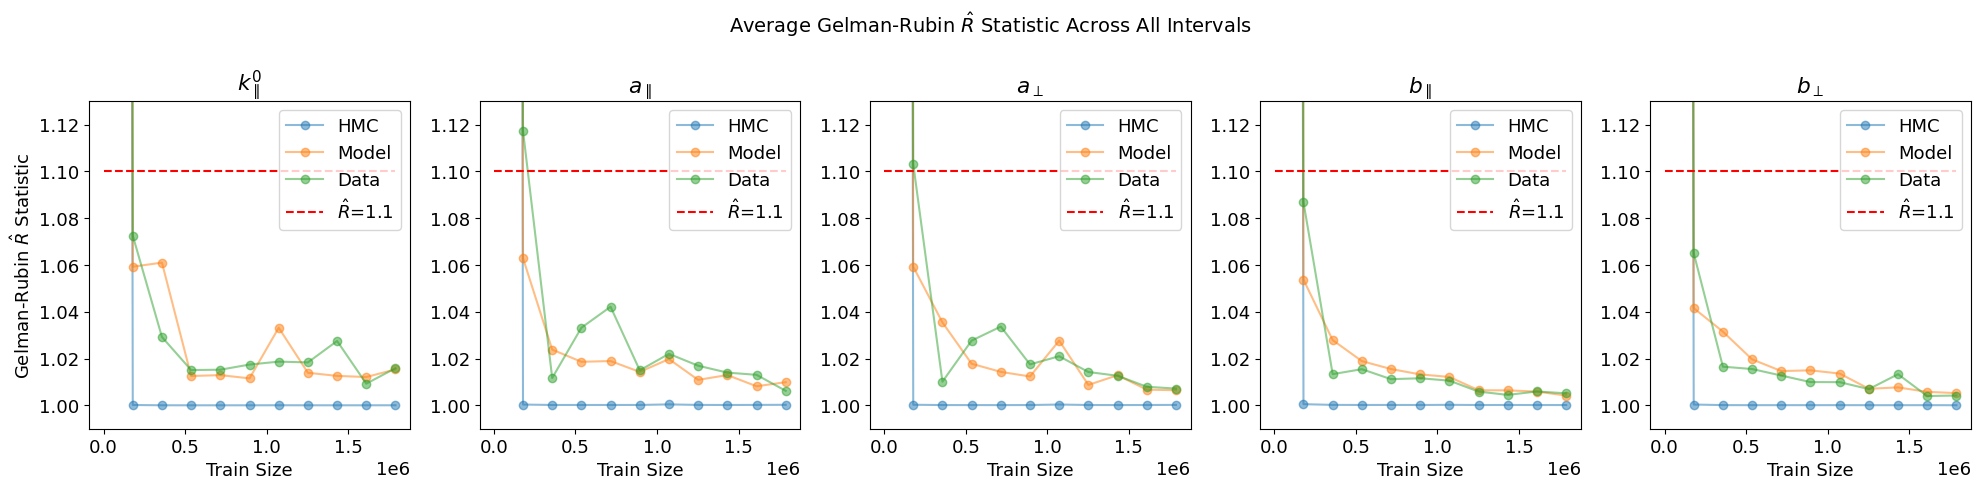

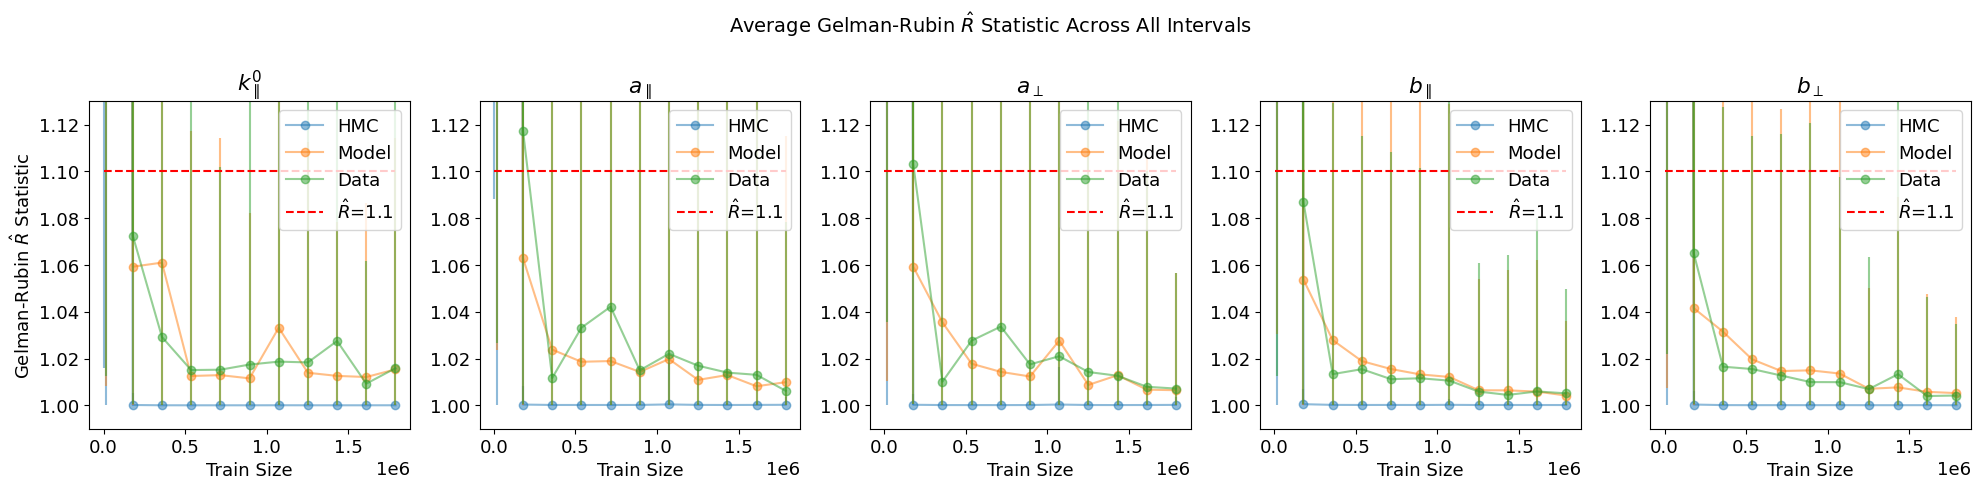

In [29]:
data_train_fractions = np.array(train_fractions) * 1_788_892 # Scale to the number of data points in the full dataset

# Let's make a 1 x 5 grid of subplots, where each plot is the distance for each parameter over all the train sizes
plt.figure(figsize=(20, 5))
plt.suptitle(r"Average Gelman-Rubin $\hat{R}$ Statistic Across All Intervals", fontsize=14)

# Plot the KL divergences
for i, param in enumerate(PARAMETERS):
    plt.subplot(1, 5, i+1)
    for j, which_change in enumerate(which_changes):
        plt.plot(data_train_fractions, avg_distances[f'{param}_{which_change}'], marker='o', alpha=0.5, label=f'{which_changes_short[j]}')
    plt.hlines(y=1.1, xmin=data_train_fractions[0], xmax=data_train_fractions[-1], color='r', linestyle='--', label=r'$\hat{R}$=1.1')
    plt.ylim(0.99, 1.13)
    plt.title(PARAMETERS_NAME[i])
    plt.xlabel('Train Size')
    # plt.yscale('log')
    plt.legend()

    if i == 0:
        plt.ylabel(r'Gelman-Rubin $\hat{R}$ Statistic')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/all_changes_all_train_sizes_all_intervals_rhat_statistic.png', dpi=300)
plt.savefig(f'../../../results/{hmc_version}/plots/all_changes_all_train_sizes_all_intervals_rhat_statistic.pdf', dpi=300)
plt.show()

# Let's make a 1 x 5 grid of subplots, where each plot is the distance for each parameter over all the train sizes
plt.figure(figsize=(20, 5))
plt.suptitle(r"Average Gelman-Rubin $\hat{R}$ Statistic Across All Intervals", fontsize=14)

# Plot the KL divergences
for i, param in enumerate(PARAMETERS):
    plt.subplot(1, 5, i+1)
    for j, which_change in enumerate(which_changes):
        plt.vlines(data_train_fractions, min_distances[f'{param}_{which_change}'], max_distances[f'{param}_{which_change}'], color=f'C{j}', alpha=0.5)
        plt.plot(data_train_fractions, avg_distances[f'{param}_{which_change}'], marker='o', alpha=0.5, label=f'{which_changes_short[j]}')
    plt.hlines(y=1.1, xmin=data_train_fractions[0], xmax=data_train_fractions[-1], color='r', linestyle='--', label=r'$\hat{R}$=1.1')
    plt.ylim(0.99, 1.13)
    plt.title(PARAMETERS_NAME[i])
    plt.xlabel('Train Size')
    # plt.yscale('log')
    plt.legend()

    if i == 0:
        plt.ylabel(r'Gelman-Rubin $\hat{R}$ Statistic')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/all_changes_all_train_sizes_all_intervals_rhat_statistic_errorbars.png', dpi=300)
plt.savefig(f'../../../results/{hmc_version}/plots/all_changes_all_train_sizes_all_intervals_rhat_statistic_errorbars.pdf')
plt.show()

Split analysis between all intervals, AMS, and PAMELA

In [30]:
# data_train_fractions = np.array(train_fractions) * 1_788_892 # Scale to the number of data points in the full dataset
# distance_versions = ['01', '02'] #, '03']
# distance_versions_long_name = ['d1_init1 & d2_init1', 'd1_init1 & d1_init2'] #, 'd1_init1_hmc1 & d1_init1_hmc2']
# intervals = ['PAMELA', 'AMS02', 'PAMELA + AMS02']

# # Make a 5 column x 3 row plot, where the top is avg over all time intervals, then AMS, then PAMELA
# plt.figure(figsize=(20, 8))
# plt.suptitle(f"{metric} distance between histograms averaged over all intervals", fontsize=14)
# for i, which_change in enumerate(distance_versions): 
#     for j, param in enumerate(PARAMETERS):
#         for interval in intervals:
#             subplot_num = i * len(PARAMETERS) + j + 1
#             plt.subplot(len(distance_versions), len(PARAMETERS), subplot_num)

#             if interval == 'PAMELA + AMS02':
#                 plt.plot(data_train_fractions, avg_distances[f'{param}_{which_change}'], marker='o', label='PAMELA + AMS02')
#             elif interval == 'PAMELA':
#                 plt.plot(data_train_fractions, avg_distances_pamela[f'{param}_{which_change}'], marker='o', label='PAMELA')
#             elif interval == 'AMS02':
#                 plt.plot(data_train_fractions, avg_distances_ams02[f'{param}_{which_change}'], marker='o', label='AMS02')

#             plt.title(f'{param}: {distance_versions_long_name[i]}')
#             plt.ylim(0.0005, 0.07)
#             plt.xlabel('Train Size')
#             plt.ylabel(f'{metric}')
#             plt.yscale('log')
#             plt.legend()

# plt.tight_layout()
# plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_average_{metric}_distance_pamela_ams.png', dpi=300)
# plt.show()